# Detect 3 Palm species in RGB UAV images

This guide provides a step-by-step of how to load an RGB UAV mosaic and detect 3 palm species:


- *Mauritia Flexuosa* (Class 1)
- *Euterpe Precatoria* (Class 2)
- *Oenocarpus Bataua* (Class 3)


Based on a model trained using ecoCNN data generation with the DeepLabv3+ and DWT architecture. For the training steps, follow the PalmsCNN_Tutorial.

This code belongs to Tagle et al. (in review) .'Overcoming the Research-Implementation Gap through Drone-based Mapping of Economically Important Amazonian Palms'

Our approach combines drone-based data with the ecoCNN data generation with the DeepLabv3+ and DWT architecture.

## 0. Loading packages
We begin by loading all the necessary libraries and modules required for the model to predict on new images.

In [1]:
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
%matplotlib inline  
from PIL import Image
import tensorflow as tf
import os
from tensorflow import keras
#from keras.models import model_from_json
from tensorflow.keras.models import load_model,model_from_json
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

#Import our modules
from Palms_Segment import model
from Palms_Segment import apply_model as apply_model_dl
from Palms_Quant.E2E_palms import apply_model as apply_model_dwt

import imageio
import cv2
import re
from Palms_Quant.E2E_palms.network_init import get_model
from tensorflow.keras import backend as kb

Instructions for updating:
non-resource variables are not supported in the long term


## 1.Set Input and Output Image Names
Define the name of the input image and specify the desired name for the predicted output image that will be generated.

In [2]:
INPUT_RASTER="/data/PIU-03_1_5.tif"
OUTPUT_RASTER="/results/"

## 2.Palm Species Mapping (Semantic Segmentation Classification)¶
In this section, we load our trained Deeplab model to generate predictions on a new image, performing semantic segmentation for palm species classification. For details on how the model was trained, refer to the "PalmsCNN_Tutorial" notebook.

In [3]:
###Model settings
window_radius = 256
output_folder = os.path.dirname(OUTPUT_RASTER)
feature_file_list= [INPUT_RASTER]
internal_window_radius = int(round(window_radius*0.75))

model_path="Palms_Segment/model"
model_path = os.path.join(model_path,"modelsavejsonR3")
json_file = open(model_path + '.json','r')
loaded_model_json = json_file.read()
json_file.close()
model_dl = model_from_json(loaded_model_json,custom_objects={'relu6':model.relu6,'BilinearUpsampling':model.BilinearUpsampling,'dice_coef':model.dice_coef  })
model_dl.load_weights(model_path+ '_weights')

###Model application
name_saved = apply_model_dl.apply_semantic_segmentation_argmax(feature_file_list,
                                    output_folder,
                                    model_dl,
                                    window_radius,
                                    internal_window_radius=internal_window_radius,
                                    make_tif=True,
                                    make_png=True,
                                    #response_file_list=response_file_list,
                                    model_assessment=False) #True when having ground truth for validation

print ("***********Prediction saved, check folder /raster/" , name_saved, "********************") 

Instructions for updating:
Colocations handled automatically by placer.


2024-10-25 04:20:06.116035: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 04:20:06.117564: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


/data/PIU-03_1_5.tif
(256, 2575)
(640, 2575)
(1024, 2575)
(1408, 2575)
(1792, 2575)
(2176, 2575)
(2319, 2575)
(1724, 2575)
***********Prediction saved, check folder /raster/ PIU-03_1_5__argmax.tif ********************


### Plotting the Results of the Palm Species Prediction (Semantic Segmentation Classification)¶

Original unique values: [0. 1. 2. 3.]
Rescaled unique values: [  0  85 170 255]


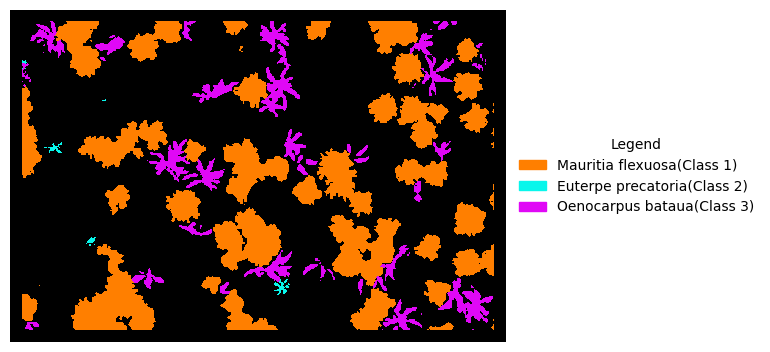

In [4]:
%matplotlib inline
# Load the TIFF image
imagen_tiff = Image.open("/results/" + name_saved)

# Convert the image to a numpy array
imagen_array = np.array(imagen_tiff)

# Print the unique original values
unique_values = np.unique(imagen_array)
print("Original unique values:", unique_values)

# Rescale the values: 0 -> 0, 1 -> 85, 2 -> 170, 3 -> 255
rescaled_image = np.interp(imagen_array, (0, 3), (0, 255)).astype(np.uint8)

# Verify the unique values after rescaling
rescaled_values = np.unique(rescaled_image)
print("Rescaled unique values:", rescaled_values)

# Create a custom color map

colors = ["#000000",      # Black (0) - Background
          "#ff7f00",       # Orange (1) - Mauritia flexuosa 
          "#08F6EB",       # Cyan (2) - Euterpe precatoria
          "#E008F6"]       # Purple (3) - Oenocarpus bataua

custom_cmap = ListedColormap(colors)

# Define the boundaries for the color map
bounds = [0, 1, 2, 3, 4]  # Add one more than the highest value to make it categorical
norm = BoundaryNorm(bounds, custom_cmap.N)

# Display the image using the custom color map
plt.imshow(imagen_array, cmap=custom_cmap, norm=norm, interpolation='nearest')

# Hide the axes (optional)
plt.axis('off')

# Create a custom vertical legend with line breaks
legend_labels = [
    mpatches.Patch(color=colors[1], label="Mauritia flexuosa(Class 1)"),
    mpatches.Patch(color=colors[2], label="Euterpe precatoria(Class 2)"),
    mpatches.Patch(color=colors[3], label="Oenocarpus bataua(Class 3)")
]

# Add the legend to the plot with vertical alignment and outside the image
plt.legend(handles=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", frameon=False)

# Show the plot
plt.show()

## 3. Palm Quantification (Instance Segmentation)
With the palm species now detected, the next step is to separate any overlapping or merged crowns. To achieve this, we apply our trained Deep Watershed Transform model, which enables us to segment individual palm crowns and quantify them.

In [6]:
###Parameters for prediction
kb.clear_session()
window_radius = 350
internal_window_radius = int(round(window_radius*0.75))
name_mask_clas = os.path.join(output_folder,name_saved)
#print(name_mask)
mask=[name_mask_clas]
roi=[]
modelWeightPaths="Palms_Quant/model"
modelWeightPaths = [os.path.join(modelWeightPaths,"dwt_onliclases_v5_045.mat")] #dwt_palms_pspsnet_v2_030

model = get_model(modelWeightPaths=modelWeightPaths)

name_saved_final, mau, eut, oeno =apply_model_dwt.apply_instance_dwt_optimizado(feature_file_list,
                                    mask,
                                    roi,
                                    output_folder,
                                    model,
                                    window_radius,
                                    internal_window_radius=internal_window_radius,
                                    make_tif=True,
                                    make_png=True)



out_imag = os.path.join(output_folder,name_saved_final)
os.rename(out_imag, OUTPUT_RASTER)
OUTPUT_RASTER_CLAS = os.path.join(OUTPUT_RASTER.split('.')[0] + '_clas.tif')
os.rename(name_mask_clas, OUTPUT_RASTER_CLAS)
kb.clear_session()
#print(mau)
# Print the report in a more detailed format
print("----- Class Count Report -----")
print(f"Input File: {OUTPUT_RASTER}")
print(f"Classified File: {OUTPUT_RASTER_CLAS}")
print("Number of pixels per class:")
print(f"Mauritia flexuosa (Class 1): {mau} palm trees")
print(f"Euterpe precatoria (Class 2): {eut} palm trees")
print(f"Oenocarpus bataua (Class 3): {oeno} palm trees")
print("--------------------------------")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use the `axis` argument instead
----- Class Count Report -----
Input File: /results/PIU-03_1_5_predicted.tif
Classified File: /results/PIU-03_1_5_predicted_clas.tif
Number of pixels per class:
Mauritia Flexuosa (Class 1): 57 palm trees
Euterpe Precatoria (Class 2): 0 palm trees
Oenocarpus Bataua (Class 3): 44 palm trees
--------------------------------


### Plotting the Results of the Palm Quantification (Instance Segmentation)

Original unique values: [ 0. 15. 35.]
Rescaled unique values: [  0 109 255]


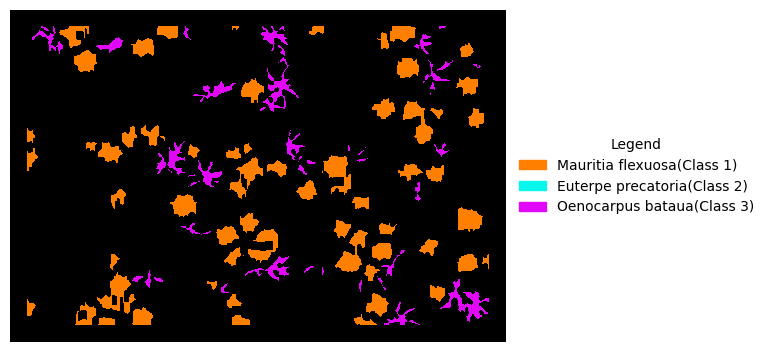

In [7]:
# Load the TIFF image
imagen_tiff = Image.open(OUTPUT_RASTER)

# Convert the image to a numpy array
imagen_array = np.array(imagen_tiff)

# Print the unique original values
unique_values = np.unique(imagen_array)
print("Original unique values:", unique_values)

# Rescale the values: 0 -> 0, 15 -> 85, 25 -> 170, 35 -> 255
rescaled_image = np.interp(imagen_array, (0, 35), (0, 255)).astype(np.uint8)

# Verify the unique values after rescaling
rescaled_values = np.unique(rescaled_image)
print("Rescaled unique values:", rescaled_values)

# Create a custom color map

colors = ["#000000",      # Black (0) - Background
          "#ff7f00",       # Orange (1) - Mauritia flexuosa 
          "#08F6EB",       # Cyan (2) - Euterpe precatoria
          "#E008F6"]       # Purple (3) - Oenocarpus bataua

custom_cmap = ListedColormap(colors)

# Define the boundaries for the color map
bounds = [0, 15, 25, 35, 40]  # Boundaries matching the unique values
norm = BoundaryNorm(bounds, custom_cmap.N)

# Display the image using the custom color map
plt.imshow(imagen_array, cmap=custom_cmap, norm=norm, interpolation='nearest')

# Hide the axes (optional)
plt.axis('off')

# Create a custom vertical legend with line breaks
legend_labels = [
    mpatches.Patch(color=colors[1], label="Mauritia flexuosa(Class 1)"),
    mpatches.Patch(color=colors[2], label="Euterpe precatoria(Class 2)"),
    mpatches.Patch(color=colors[3], label="Oenocarpus bataua(Class 3)")
]


# Add the legend to the plot with vertical alignment and outside the image
plt.legend(handles=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", frameon=False)

# Show the plot
plt.show()

Done! The raster is now ready for vectorization. This allows us to extract the centroids of each palm crown, enabling the creation of a detailed heatmap for assessing palm abundance or utilizing this layer for various other purposes. 

In [8]:
### Import libraries needed
from osgeo import gdal, ogr, osr

import geopandas as gd
import pandas as pd
import os


###Load the  prediction
list_in_path=[
'/results/PIU-03_1_5_predicted.tif',
]


### Vectorize, calculate area and extract the centroids
for in_path in list_in_path:
    if  os.path.exists(in_path)==False:
        print("XXXXXXXXX NOT FOUND xxxxxxxxxxX")
        print("in_path",in_path)
        print("XXXXXXXXX END xxxxxxxxxxX")
        continue
    print("=====================START================")
    print("in_path",in_path)
    ###Output info
    out_POL_path = os.path.join(in_path.split('.tif')[0] + '_poly.gpkg') #Polygon
    out_CEN_path = os.path.join(in_path.split('.tif')[0] + '_centers.gpkg') #centroids
    out_CSV_path = os.path.join(in_path.split('.tif')[0] + '_atributos.csv') #attributes
    
    print(out_POL_path)
    ###GDAL polygonize
    #  get raster datasource
    src_ds = gdal.Open( in_path )
    #
    srcband = src_ds.GetRasterBand(1)
    dst_layername = 'palms_Area_ha'
    drv = ogr.GetDriverByName("GPKG")
    #drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource( out_POL_path )
    prj=src_ds.GetProjection()

    sp_ref = osr.SpatialReference()
    sp_ref = osr.SpatialReference(wkt=prj)
    #sp_ref.SetFromUserInput('EPSG:4326')

    dst_layer = dst_ds.CreateLayer(dst_layername, srs = sp_ref )

    fld = ogr.FieldDefn("ID", ogr.OFTInteger)
    dst_layer.CreateField(fld)
    dst_field = dst_layer.GetLayerDefn().GetFieldIndex("ID")

    ###Vectorize the raster
    gdal.Polygonize( srcband, None, dst_layer, dst_field, [], callback=None )

    del src_ds
    del dst_ds

    ###Get Centroids from the generated vector
    gdf = gd.read_file(out_POL_path)
    gdf.info()
    gdf=gdf[gdf["ID"]>0]


    ###Function to generate a table with some attributes

    c1=0 #count each palm
    c2=0
    c3=0
    ca1=0 #sum all the area
    ca2=0
    ca3=0
    def generateCentroidColumns(item):
        global c1
        global c2
        global c3
        global ca1
        global ca2
        global ca3
        ESPECIE = 'Mauritia flexuosa'
        geom = item.geometry
        if (item['ID'] == 15) : #0=FIELD ID
            ESPECIE = 'Mauritia flexuosa' #2= FIELD ESPECIE
            c1 = c1+1
            ca1 = ca1 + geom.area
        elif (item['ID'] == 25):
            ESPECIE = 'Euterpe precatoria'
            c2 = c2+1
            ca2 = ca2 + geom.area
        elif(item['ID'] == 35):
            ESPECIE = 'Oenocarpus bataua'
            c3 = c3+1
            ca3 = ca3 + geom.area

        areacopa=geom.area  #3= FIELD ESPECIE
        cx = geom.centroid.x#4= FIELD UTMESTE
        cy = geom.centroid.y #5= FIELD UTMNORTE
        clase = item['ID'] #1= CLASE
    

        return pd.Series([clase, ESPECIE, areacopa,cx,cy])


        
    ###Apply function to obtain centroids with info
    gdf[['ID','ESPECIE','ÁREA(m2)','UTM(ESTE)','UTM(NORTE)']]=gdf.apply(generateCentroidColumns,axis=1)

    print(gdf.head())

    def generarcentroid(item):
        return pd.Series([item.ESPECIE, item.geometry.centroid])
    dfcentroid=gdf.apply(generarcentroid,axis=1).set_axis(['ESPECIE', 'geometry'], axis=1, inplace=False)
    #dfcentroid.set_geometry(col='geometry', inplace=True)
    # Crear un GeoDataFrame desde el DataFrame
    dfcentroid = gd.GeoDataFrame(dfcentroid, geometry='geometry')
    
    print(dfcentroid.head())
    gdf.to_file(out_POL_path)
    dfcentroid.to_file(out_CEN_path)

    

    print("=====================END================")

=====================START================
in_path /results/PIU-03_1_5_predicted.tif
/results/PIU-03_1_5_predicted_poly.gpkg
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        106 non-null    int32   
 1   geometry  106 non-null    geometry
dtypes: geometry(1), int32(1)
memory usage: 1.4 KB
   ID                                           geometry            ESPECIE  \
0  35  POLYGON ((561748.156 9552293.779, 561749.742 9...  Oenocarpus bataua   
1  15  POLYGON ((561697.634 9552293.779, 561697.634 9...  Mauritia flexuosa   
2  35  POLYGON ((561710.09 9552293.779, 561710.416 95...  Oenocarpus bataua   
3  35  POLYGON ((561651.357 9552293.779, 561651.357 9...  Oenocarpus bataua   
4  15  POLYGON ((561717.367 9552293.779, 561719.933 9...  Mauritia flexuosa   

   ÁREA(m2)      UTM(ESTE)    UTM(NORTE)  
0  0.807379  561748.685677  9.5522